In [2]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [4]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)
a

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [7]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表中。"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.time)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsun(self):
        """返回累计时间"""
        return np.array(self.times).cusum().tilist()
        

In [13]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

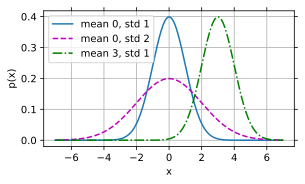

In [14]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 线性回归的从零开始实现

我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。 我们使用线性模型参数w=[2,−3.4]⊤、b=4.2和噪声项ϵ生成数据集及其标签：

## y=Xw+b+ϵ

In [3]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))

true_w = torch.tensor([2, 3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


features 中的每一行都包含一个二维数据样本，labels 中的每一行都包含一维标签值（一个标量）

In [5]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.5957,  0.3662]) 
label: tensor([4.2627])


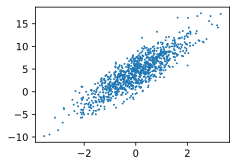

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

定义一个data_iter 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [38]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indics = list(range(num_examples))
    # 样本是随机的，没有特定的顺序
    random.shuffle(indics)
    for i in range (0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indics[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break       

tensor([[ 0.7162, -1.5242],
        [ 2.2956, -0.7711],
        [-1.0981, -1.1063],
        [ 1.5572,  1.6968],
        [ 0.0067,  0.0833],
        [-0.6092, -0.0208],
        [-1.3443, -2.1271],
        [ 1.7101,  0.6567],
        [-0.0407,  0.5451],
        [ 0.1841, -0.5105]]) 
 tensor([[ 0.4421],
        [ 6.1659],
        [-1.7293],
        [13.0995],
        [ 4.5110],
        [ 2.8938],
        [-5.7385],
        [ 9.8730],
        [ 5.9792],
        [ 2.8372]])


定义 初始化模型参数·

In [32]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0152],
         [ 0.0023]], requires_grad=True),
 tensor([0.], requires_grad=True))

定义模型

In [33]:
def linreg(x, w, b):
    """线性回归模型"""
    return torch.matmul(x, w) + b

定义损失函数

In [35]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [46]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            

训练过程

In [47]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x, y in data_iter(batch_size, features, labels):
        l = loss(net(x, w, b), y)
        # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  
        # 使用参数的梯度更新参数
        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 12.513852
epoch 1, loss 11.358687
epoch 1, loss 10.439415
epoch 1, loss 9.698470
epoch 1, loss 9.359729
epoch 1, loss 8.986931
epoch 1, loss 8.400063
epoch 1, loss 7.904667
epoch 1, loss 7.484432
epoch 1, loss 6.725669
epoch 1, loss 6.369967
epoch 1, loss 5.812262
epoch 1, loss 5.482518
epoch 1, loss 5.033060
epoch 1, loss 4.816301
epoch 1, loss 4.474462
epoch 1, loss 4.203991
epoch 1, loss 4.069439
epoch 1, loss 3.947345
epoch 1, loss 3.729368
epoch 1, loss 3.509429
epoch 1, loss 3.358052
epoch 1, loss 3.023265
epoch 1, loss 2.884242
epoch 1, loss 2.740002
epoch 1, loss 2.517513
epoch 1, loss 2.400401
epoch 1, loss 2.199212
epoch 1, loss 2.081712
epoch 1, loss 1.917721
epoch 1, loss 1.840819
epoch 1, loss 1.744980
epoch 1, loss 1.689549
epoch 1, loss 1.623237
epoch 1, loss 1.584779
epoch 1, loss 1.522465
epoch 1, loss 1.456393
epoch 1, loss 1.361533
epoch 1, loss 1.299827
epoch 1, loss 1.212105
epoch 1, loss 1.115111
epoch 1, loss 1.030948
epoch 1, loss 0.954686
epoch 1,

比较真实参数和通过训练学到的参数来评估训练的成功程度

In [48]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003,  0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


**关于tensor中grade的用法使用**

In [49]:
import torch
a=torch.tensor([1.,2,3,4],requires_grad=True)
b=torch.tensor([1.,2,3,4],requires_grad=False) #默认False
c=torch.sum(a*2)
c.backward()
print(a.grad)

d=torch.sum(b+a)
d.backward()
print(b.grad)
print(b.requires_grad)

tensor([2., 2., 2., 2.])
None
False


In [50]:
a=torch.tensor([1.,2,3,4],requires_grad=True)
b=torch.tensor([1.,2,3,4],requires_grad=False) #默认false
c=a+b
print(a.grad_fn,b.grad_fn)
print(c.grad_fn)
print(c)

None None
tensor([2., 4., 6., 8.], grad_fn=<AddBackward0>)
